# Redes Neurais

- http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
- http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\RR}{\mathbb{R}}$

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ipywidgets import interact, FloatLogSlider, FloatSlider

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, PredefinedSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
root_mean_squared_error = lambda a, b: ((a-b)**2).mean()**0.5
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def grid_search_holdout(model, param_grid, X_train, y_train, X_val, y_val):
    val_index = [-1]*len(X_train) + [0]*len(X_val)
    gs = GridSearchCV(model, param_grid, refit=False, cv=PredefinedSplit(val_index))
    gs.fit(np.r_[X_train, X_val], np.r_[y_train, y_val])
    return gs

In [ ]:
def plot_data(X, y, model=None, **kwargs):
    if y.dtype.kind == 'f':
        return plot_data_reg(X, y, model, **kwargs)
    else:
        return plot_data_clf(X, y, model, **kwargs)

def plot_data_reg(X, y, model=None, N=1000):
    plt.plot(X, y, 'b.', label='data');
    plt.xlabel('x')
    plt.ylabel('y')
    if model is not None:
        plt.plot(X, model.predict(X), 'r.')
        x = np.linspace(X.min(), X.max(), N)
        plt.plot(x, model.predict(x.reshape(-1, 1)), 'r-', label=type(model).__name__)
    plt.legend()
    plt.grid()
    return

def plot_data_clf(X, y, model=None, heatmap=False, margin=True, support=True, errors=False,
              legend=True, colors=['bo','rx','gd','ms','c^','yP'], reverse_colors=False, N=100, gap=1e-9):
    '''Plot 1-D or 2-D classification dataset and classifier decision regions'''
    assert len(X.shape) == 2 and len(y.shape) == 1
    classes = list(np.unique(y))
    if model is not None:
        assert set(classes) <= set(model.classes_)
        classes = list(model.classes_)
    assert len(classes) <= len(colors)
    cmap = 'bwr'
    if reverse_colors:
        colors = colors[1::-1] + colors[2:]
        cmap = 'bwr_r'
    dim = X.shape[1]
    assert 0 < dim <= 2
    if dim == 1:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i]], np.zeros(np.sum(y == classes[i])), colors[i], label=classes[i])
        plt.gca().axes.get_yaxis().set_ticks([])
        plt.xlabel('x')
    else:
        for i in range(len(classes)):
            plt.plot(X[y == classes[i], 0], X[y == classes[i], 1], colors[i], label=classes[i])
        plt.xlabel('x1')
        plt.ylabel('x2')
    if legend:
        plt.legend()
    if model is None:
        return
    x1_min, x1_max = X[:,0].min()-gap, X[:,0].max()+gap
    if dim == 1:
        x2_min, x2_max = -1, 1
        N2 = 2
    else:
        x2_min, x2_max = X[:,1].min()-gap, X[:,1].max()+gap
        N2 = N
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, N), np.linspace(x2_min, x2_max, N2))
    if dim == 1:
        XX = np.c_[xx1.reshape(-1)]
    else:
        XX = np.c_[xx1.reshape(-1), xx2.reshape(-1)]
    if errors:
        err = model.predict(X) != y
        vert = X[err, 1] if dim == 2 else np.zeros(np.sum(err))
        plt.plot(X[err, 0], vert, 'ks', mfc='none', markersize=10)
    if len(classes) > 2:
        y_pred = model.predict(XX)
        y_pred = np.array([classes.index(a) for a in y_pred])
        y_pred = y_pred.reshape(xx1.shape)
        levels = np.arange(len(classes) + 1) - 0.5
        plt.contour(xx1, xx2, y_pred, levels, colors='k', linewidths=1)
        plt.contourf(xx1, xx2, y_pred, levels, colors=[c[0] for c in colors], alpha=0.25)
        return
    if hasattr(model, 'predict_proba'):
        p = model.predict_proba(XX)[:,1].reshape(xx1.shape)
        plt.contour(xx1, xx2, p, levels=[0.5], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, p, levels=[-np.inf, 0.5, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if heatmap:
            plt.contourf(xx1, xx2, p, levels=100, cmap=cmap, vmin=-1, vmax=2)
    else:
        z = model.decision_function(XX).reshape(xx1.shape)
        plt.contour(xx1, xx2, z, levels=[0], colors='k', linewidths=1)
        plt.contourf(xx1, xx2, z, levels=[-np.inf, 0, np.inf], colors=[c[0] for c in colors], alpha=0.25)
        if margin:
            plt.contourf(xx1, xx2, z, levels=[-1, 0, 1], cmap=cmap, vmin=-3, vmax=3)
        if heatmap:
            a = np.max(np.abs(z))*2
            plt.contourf(xx1, xx2, z, 100, cmap=cmap, vmin=-a, vmax=a)
        if support and hasattr(model, 'support_'):
            S = X[model.support_]
            if dim == 1:
                S = np.c_[S, np.zeros(S.shape[0])]
            plt.plot(*S.T, 'go', mfc='none', ms=12)
    return

## Conceitos básicos

### Classificação

(300, 2) (300,)
(100, 2) (100,)


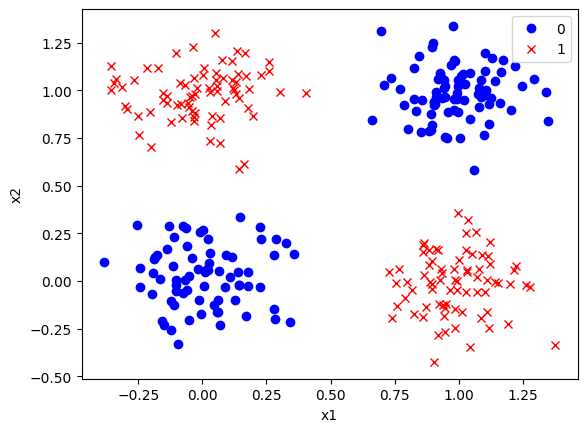

In [ ]:
X_train, y_train = make_blobs(n_samples=400, n_features=2, centers=[[0,0],[1,1],[0,1],[1,0]], cluster_std=0.15, random_state=0)
y_train = (y_train >= 2).astype(int)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/4, random_state=0)
plot_data(X_train,y_train)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

#### Regressão logística

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Train accuracy: 49.3%
  Val accuracy: 45.0%


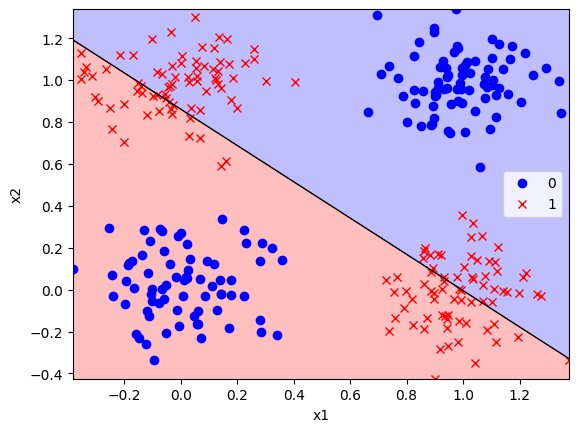

In [ ]:
model = LogisticRegression(penalty='none')
model.fit(X_train, y_train)
plot_data(X_train, y_train, model)
#plot_data(X_train, y_train, model, heatmap=True); plt.colorbar()
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')

In [ ]:
from sklearn.metrics import log_loss
print('b =', model.intercept_[0])
print('w =', model.coef_[0])
p = model.predict_proba(X_train)[:, 1]
print('p_min =', p.min())
print('p_max =', p.max())
print('Train loss:', log_loss(y_train, p))

b = 0.1399641644152097
w = [-0.14072583 -0.16260896]
p_min = 0.4464256177971812
p_max = 0.5517594182952916
Train loss: 0.6916295120000056


$\text{BCE}(y, p) = - y \log (p) - (1 - y) \log (1 - p)$

In [ ]:
np.log(2)

0.6931471805599453

#### Redes neurais

- Rede neural sem nenhuma camada oculta (i.e., com apenas a camada de saída) com ativação de saída logística e sem regularização, usando `solver='lbfgs'`
- `alpha` é o parâmetro de regularização, equivalente a `1/C`.
- O parâmetro `activation` refere-se à ativação das **camadas ocultas** e portanto é irrelevante neste caso particular
- A ativação da camada de saída é escolhida [automaticamente](https://github.com/scikit-learn/scikit-learn/blob/832513a7fb6570c41f3c8bf4bf7cbaf110da300e/sklearn/neural_network/_multilayer_perceptron.py#L329) pela função dependendo do tipo de modelo e da variável de saída (linear se for um regressor ou, no caso de um classificador, logística se é $y$ categórico com 2 classes ou softmax se $y$ é categórico com mais de 2 classes):

![image.png](attachment:d67f3a1e-e4ea-4bfa-9d52-d722bfc6acd4.png)

- Obs: ocorre um erro caso se tente treinar um classificador com $y$ *float* não-inteiro ou um regressor com $y$ não-numérico

Train accuracy: 49.3%
  Val accuracy: 45.0%


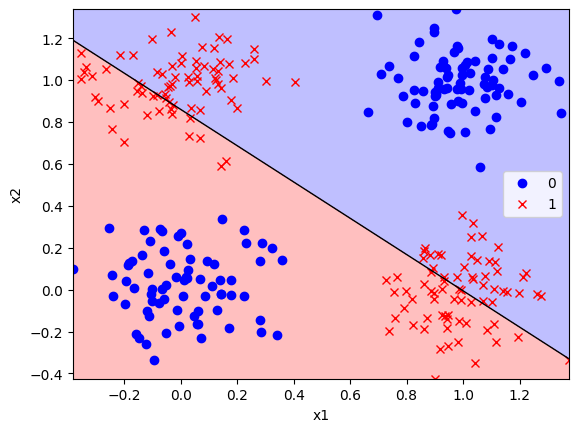

In [ ]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=[], alpha=0, solver='lbfgs')
model.fit(X_train, y_train)
plot_data(X_train, y_train, model)
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')

In [ ]:
print('b =', model.intercepts_[0][0])
print('w =', model.coefs_[0].T[0])
p = model.predict_proba(X_train)[:, 1]
print('output activation:', model.out_activation_)
print(f'Train loss: {model.loss_}')
print(f' Train BCE: {log_loss(y_train, model.predict_proba(X_train)[:, 1])}')

b = 0.13925558727379023
w = [-0.1401561  -0.16202648]
output activation: logistic
Train loss: 0.6916295354311564
 Train BCE: 0.6916295354311564


- Ao contrário da maior parte da literatura, a sklearn contabiliza a camada de entrada no número de camadas da rede (`n_layers_`)
- O número de camadas "de fato" (camadas ocultas + camada de saída) é dado por `len(model.coefs_)` pois cada camada introduz uma matriz de pesos

In [ ]:
model.n_layers_

2

In [ ]:
len(model.coefs_)

1

In [ ]:
model.coefs_[0].T[0]

array([-0.1401561 , -0.16202648])

Train accuracy: 49.3%
  Val accuracy: 45.0%


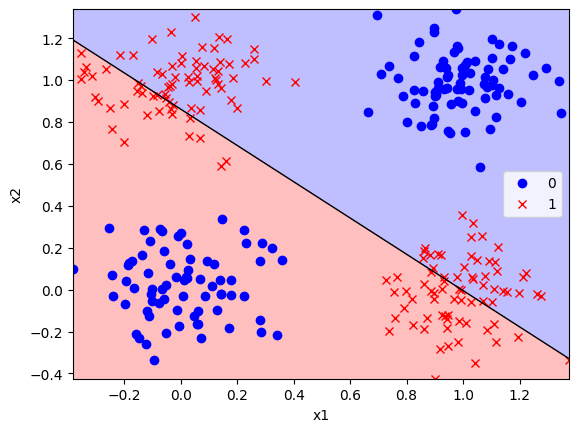

In [ ]:
model = MLPClassifier(hidden_layer_sizes=[5, 4, 3], activation='identity', alpha=0, solver='lbfgs')
model.fit(X_train, y_train)
plot_data(X_train, y_train, model)
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')

In [ ]:
model.coefs_[0]

array([[ 0.43304957, -0.73542164, -0.72365007,  0.44578876, -0.79353447],
       [ 0.23363435,  0.86370217, -0.61552222, -0.8939839 ,  0.70303476]])

In [ ]:
model.coefs_[1]

array([[-0.16107525, -0.80056616, -0.05036383,  0.6258511 ],
       [ 0.51831374, -0.20547648, -0.72336579,  0.68450421],
       [ 0.20983814, -0.7939499 ,  0.40954023,  0.64483331],
       [-0.12395921,  0.37150536, -0.43420089,  0.67968638],
       [-0.00676508,  0.59981638, -0.00884923,  0.63491292]])

In [ ]:
model.coefs_[2]

array([[-0.50685995, -0.89199487,  0.20176472],
       [-0.98514498,  0.44473024,  0.35112588],
       [-0.70578574,  0.13405687, -0.30953796],
       [ 0.12456617,  0.19872979, -0.3982439 ]])

In [ ]:
model.coefs_[0] @ model.coefs_[1] @ model.coefs_[2]

array([[ 0.13189358,  0.43752354,  0.24231817],
       [-0.02677134, -0.28238214,  0.23857237]])

- Com ativação linear nas camadas ocultas (`activation='identity'`), o resultado é sempre o mesmo, independente do número de camadas ocultas e do número de unidades por camada. Por quê?
- Com ativação logística, mesmo com uma única camada oculta com 2 unidades, já é possível (às vezes) obter uma classificação praticamente perfeita. Mas por que varia tanto a cada `random_state`?
- Aumentando o número de unidades da camada oculta, essa variação diminui.
- Aumentando também a regularização, a variação diminui ainda mais.

In [ ]:
[10]*0

[]

interactive(children=(Dropdown(description='activation', index=1, options=('identity', 'logistic', 'tanh', 're…

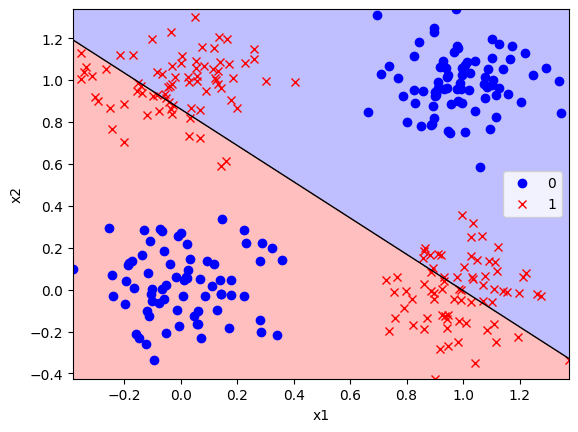

In [ ]:
@interact(activation=['identity', 'logistic', 'tanh', 'relu'], n_hid_layers=(0,4), hid_layer_size=(1,20),
          alpha=FloatLogSlider(value=0, min=-6, max=0, step=0.5, readout_format='.2e'), random_state=(0,20))
def _(activation='logistic', n_hid_layers=0, hid_layer_size=10, alpha=None, random_state=0):
    model = MLPClassifier(hidden_layer_sizes=[hid_layer_size]*n_hid_layers, activation=activation, alpha=alpha, solver='lbfgs', random_state=random_state)
    model.fit(X_train, y_train)
    plot_data(X_train, y_train, model)
    print(f'Train loss: {model.loss_}')
    print(f' Train BCE: {log_loss(y_train, model.predict_proba(X_train)[:, 1])}')
    print(f'   Val BCE: {log_loss(y_val, model.predict_proba(X_val)[:, 1])}')
    print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
    print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')

### Regressão

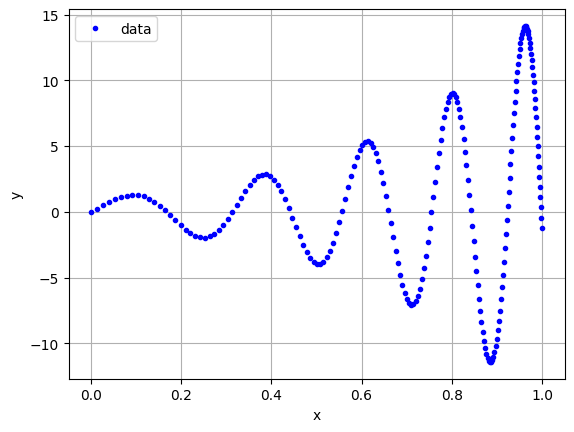

In [ ]:
def gen_data(n_samples=200, noise_std=0.0, random_state=None):
    '''Generate univariate regression dataset'''
    rng = np.random.RandomState(random_state)
    x = rng.permutation(1 - np.exp(-np.linspace(0, 2.5, n_samples)))
    y = np.sin(2*np.pi*3*np.exp(x))*np.exp(3*x) + noise_std*rng.randn(n_samples)
    x = x/x.max()
    X = x.reshape(-1, 1)
    return X, y

X_train, y_train = gen_data(random_state=0)
plot_data(X_train, y_train)

- [MLPRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) implementa uma rede neural com ativação de saída linear e perda quadrática
- Sem camadas ocultas = regressão linear por mínimos quadrados

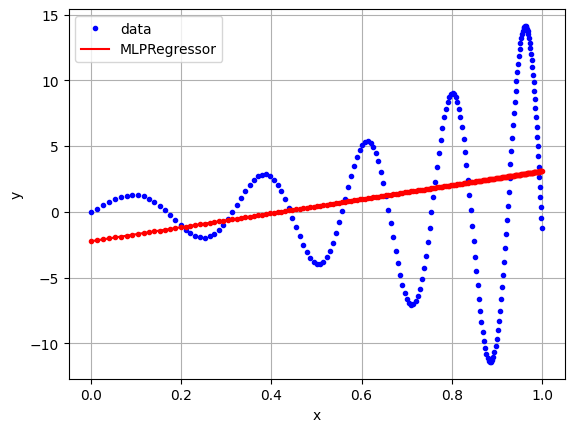

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[], alpha=0, solver='lbfgs')
model.fit(X_train, y_train)
plot_data(X_train, y_train, model)

interactive(children=(Dropdown(description='activation', index=1, options=('identity', 'logistic', 'tanh', 're…

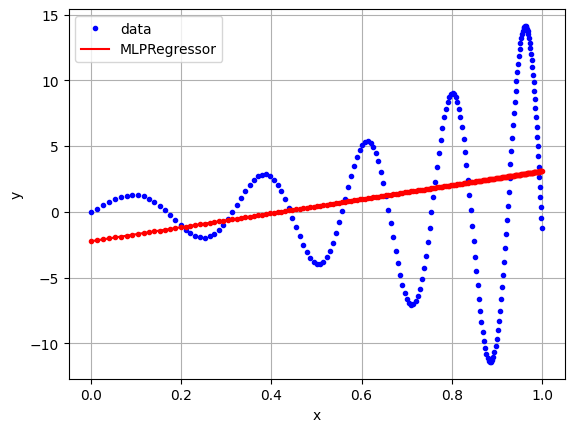

In [ ]:
@interact(activation=['identity', 'logistic', 'tanh', 'relu'], n_hid_layers=(0,4), hid_layer_size=(1,50), max_iter=[200, 1000, 2000, 5000],
          alpha=FloatLogSlider(value=0, min=-24, max=0, step=0.5, readout_format='.2e'), random_state=(0,20))
def _(activation='logistic', n_hid_layers=0, hid_layer_size=10, alpha=None, max_iter=1000, random_state=0):
    model = MLPRegressor(hidden_layer_sizes=[hid_layer_size]*n_hid_layers, activation=activation, alpha=alpha, max_iter=max_iter, solver='lbfgs', random_state=random_state)
    model.fit(X_train, y_train)
    plot_data(X_train, y_train, model)
    print('Iterations:', model.n_iter_)
    print(f'Train 2*loss: {2*model.loss_}')
    print(f'   Train MSE: {mean_squared_error(y_train, model.predict(X_train))}')
    print(f'  Train RMSE: {root_mean_squared_error(y_train, model.predict(X_train))}')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Iterations: 5000
 Train MSE: 0.00444353015541582
Train RMSE: 0.06665980914626009


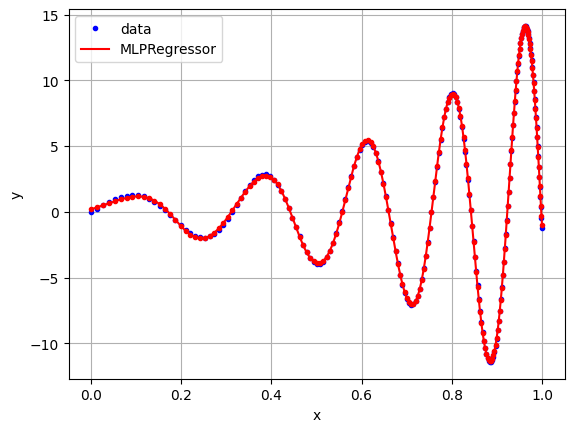

In [ ]:
model = MLPRegressor(hidden_layer_sizes=[30], activation='logistic', solver='lbfgs', alpha=1e-3, max_iter=5000, random_state=3)
model.fit(X_train, y_train)
plot_data(X_train, y_train, model)
print('Iterations:', model.n_iter_)
print(f' Train MSE: {mean_squared_error(y_train, model.predict(X_train))}')
print(f'Train RMSE: {root_mean_squared_error(y_train, model.predict(X_train))}')

- Funções (do único atributo de entrada, $x$) produzidas pelas unidades da primeira camada oculta. Note que $a = g(w x + b)$ representa a ativação produzida pela unidade.

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

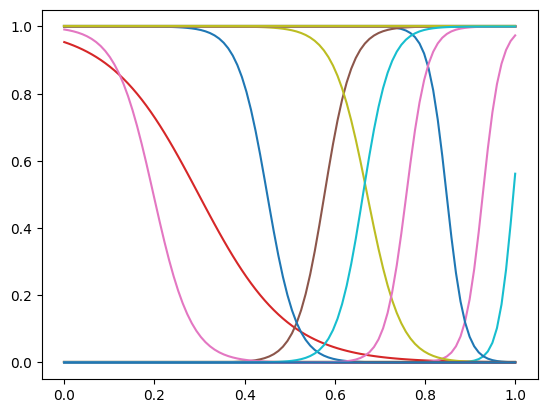

In [ ]:
from scipy.special import expit as sigmoid
assert model.n_layers_ - 2 >= 1, 'Must have at least one hidden layer'
n = model.intercepts_[0].shape[0]
@interact(i=(0,n-1))
def plot_first_layer(i=0):
    b = model.intercepts_[0][i]
    w = model.coefs_[0][0, i]
    x = np.linspace(0, 1, 100)
    a = sigmoid(b + w*x)
    plt.plot(x, a, '-')
    plt.ylim([-0.05, 1.05])
for i in range(n):
    plot_first_layer(i)

Considerando que o modelo possui uma única camada oculta, a função implementada pelo modelo é dada por:

$f(x) = b^{[1]} + \bW^{[1]} g(\bb^{[0]} + \bW^{[0]}x)$

onde $\bW^{[0]}$ é $n \times 1$ e $\bW^{[1]}$ é $1 \times n$.

Ou, usando a notação (row-major, i.e., vetores como linhas) do sklearn/NumPy:

$f(x) = g(x\bW^{[0]} + \bb^{[0]}) \bW^{[1]} + b^{[1]}$

onde $\bW^{[0]}$ é $1 \times n$ e $\bW^{[1]}$ é $n \times 1$.

Ou, nesse caso particular, simplesmente:

$f(x) =  b^{[1]} + \sum_{i=1}^{n} w^{[1]}_i g(b^{[0]}_i + w^{[0]}_i x)$

interactive(children=(IntSlider(value=0, description='i', max=29), Output()), _dom_classes=('widget-interact',…

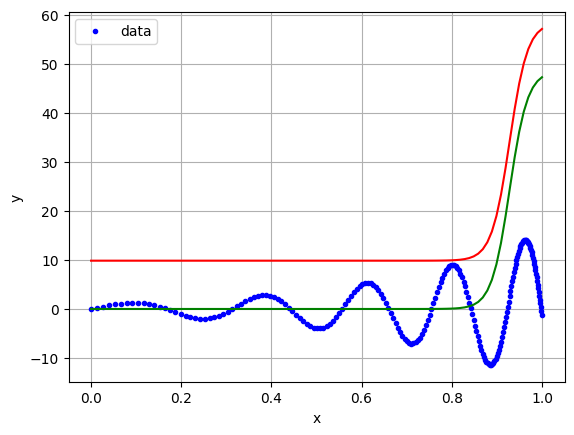

In [ ]:
x = np.linspace(0, 1, 100)
n = model.intercepts_[0].shape[0]
order = np.abs(model.coefs_[1][:,0]).argsort()[::-1]
@interact(i=(0,n-1))
def _(i=0):
    a = model.intercepts_[1] + np.zeros(len(x))
    for j in range(i+1):
        b = model.intercepts_[0][order[j]]
        w = model.coefs_[0][0, order[j]]
        w1 = model.coefs_[1][order[j], 0]
        h = w1*sigmoid(b + w*x)
        a = a + h
    print(f'b[1] = {model.intercepts_[1][0]:.4g}\n')
    print(f'w[1][i] = {w1:.4g}\n')
    print(f'f[0](x)_i = sigmoid({b:.4g} + {w:.4g}*x)\n')
    plot_data(X_train, y_train)
    plt.plot(x, a, 'r-');
    plt.plot(x, h, 'g-');

## Controlando overfitting

### Classificação

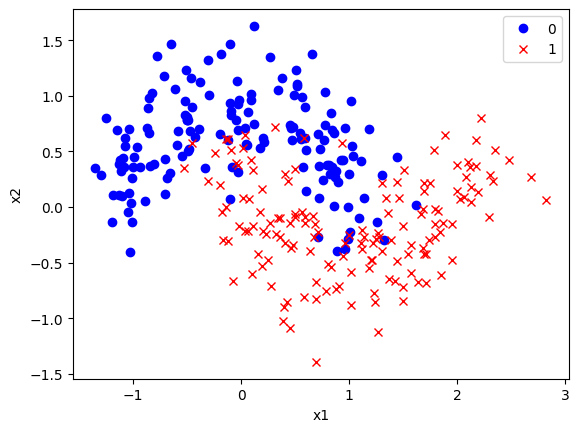

In [ ]:
X_train, y_train = make_moons(n_samples=300, noise=0.3, random_state=7)
X_val,   y_val   = make_moons(n_samples=10000, noise=0.3, random_state=1)
X_test,  y_test  = make_moons(n_samples=10000, noise=0.3, random_state=2)
plot_data(X_train, y_train)

Train accuracy (SVC): 89.33%
  Val accuracy (SVC): 90.21%


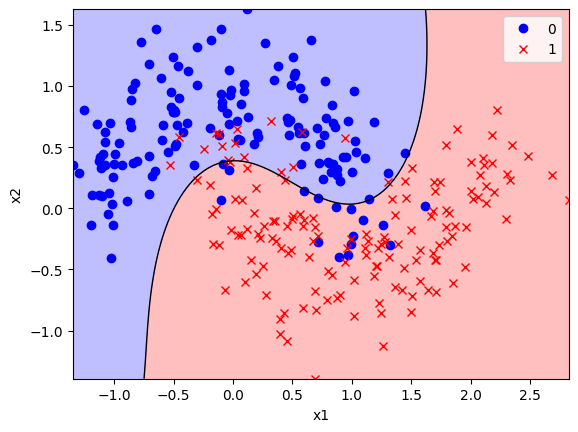

In [ ]:
from sklearn.svm import SVC
model = SVC().fit(X_train, y_train)
print(f'Train accuracy ({type(model).__name__}): {model.score(X_train, y_train):.2%}')
print(f'  Val accuracy ({type(model).__name__}): {model.score(X_val, y_val):.2%}')
plot_data(X_train, y_train, model, support=False, margin=False)

Flexibilidade das redes neurais

- Com uma **única** camada oculta com ativação logística (mas com um número suficiente grande de unidades e quantas iterações forem necessárias), é possível obter 100% de acurácia no conjunto de treinamento
- Overfitting pode ser controlado aumentando a regularização e/ou limitando o número de iterações

interactive(children=(Dropdown(description='activation', index=1, options=('identity', 'logistic', 'tanh', 're…

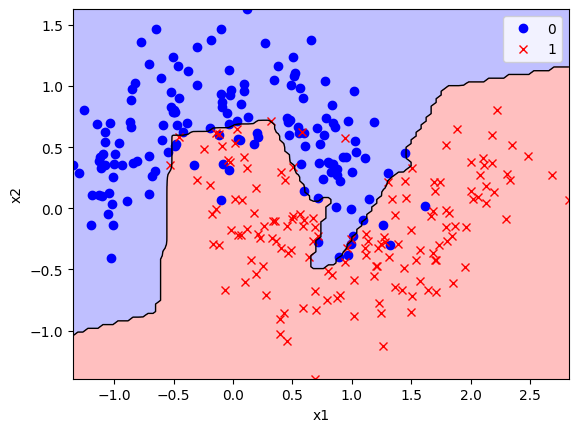

In [ ]:
@interact(activation=['identity', 'logistic', 'tanh', 'relu'], n_hid_layers=(0,4), hid_layer_size=(1,200),
          alpha=FloatLogSlider(value=0, min=-6, max=0, step=0.5, readout_format='.2e'), max_iter=(100,2000,100), random_state=(0,20))
def _(activation='logistic', n_hid_layers=1, hid_layer_size=10, alpha=None, max_iter=200, random_state=0):
    model = MLPClassifier(hidden_layer_sizes=[hid_layer_size]*n_hid_layers, activation=activation, alpha=alpha, solver='lbfgs', max_iter=max_iter, random_state=random_state)
    model.fit(X_train, y_train)
    plot_data(X_train, y_train, model)
    print('Iterations:', model.n_iter_)
    print(f'Train loss: {model.loss_}')
    print(f' Train BCE: {log_loss(y_train, model.predict_proba(X_train)[:, 1])}')
    print(f'   Val BCE: {log_loss(y_val, model.predict_proba(X_val)[:, 1])}')
    print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
    print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')
    #hid_layer_size=200, max_iter=2000, alpha=1e-6
    #hid_layer_size=200, max_iter=2000, alpha=3.16e-2
    #hid_layer_size=200, max_iter=100, alpha=1e-6

### Regressão

In [ ]:
def gen_data(n_samples, random_state):
    rng = np.random.RandomState(random_state)
    x = np.linspace(0, 1, n_samples)
    y = 50*np.cos(4*np.pi*x) + 10*rng.standard_normal(size=n_samples)
    X = x.reshape(-1, 1)
    return X, y

(20, 1) (100000, 1) (100000, 1)


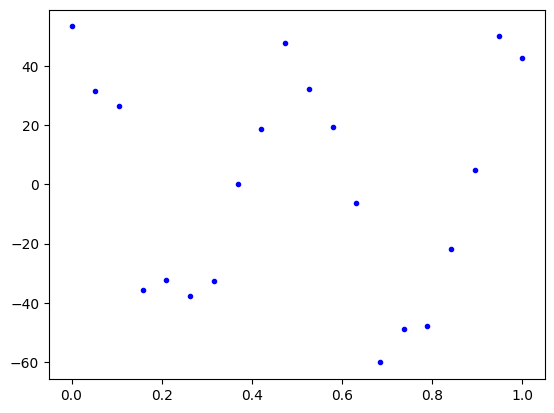

In [ ]:
X_train, y_train = gen_data(20, random_state=110)
X_val, y_val = gen_data(100000, random_state=2)
X_test, y_test = gen_data(100000, random_state=5)
print(X_train.shape, X_val.shape, X_test.shape)

plt.plot(X_train, y_train, 'b.');

interactive(children=(Dropdown(description='activation', index=1, options=('identity', 'logistic', 'tanh', 're…

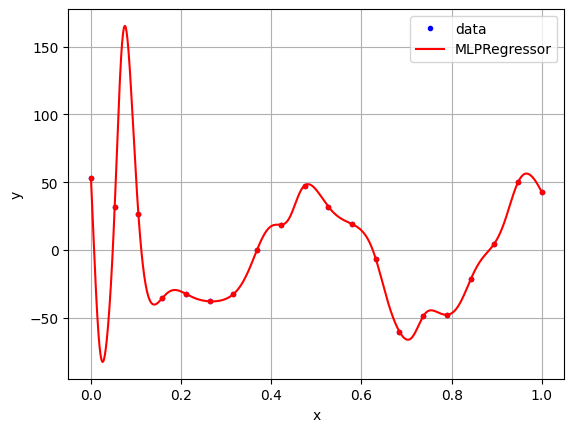

In [ ]:
@interact(activation=['identity', 'logistic', 'tanh', 'relu'], n_hid_layers=(0,4), hid_layer_size=(10,500,10), max_iter=(200, 5000, 100),
          alpha=FloatLogSlider(value=0, min=-6, max=0, step=0.1, readout_format='.2e'), random_state=(0,20))
def _(activation='logistic', n_hid_layers=1, hid_layer_size=100, alpha=None, max_iter=1000, random_state=0):
    model = MLPRegressor(hidden_layer_sizes=[hid_layer_size]*n_hid_layers, activation=activation, alpha=alpha, max_iter=max_iter, solver='lbfgs', random_state=random_state)
    model.fit(X_train, y_train)
    plot_data(X_train, y_train, model)
    print('Iterations:', model.n_iter_)
    print(f'Train 2*loss: {2*model.loss_}')
    print(f'   Train MSE: {mean_squared_error(y_train, model.predict(X_train))}')
    print(f'     Val MSE: {mean_squared_error(y_val, model.predict(X_val))}')

  Train MSE: 63.074985719180816
    Val MSE: 144.70633254130476
   Test MSE: 145.86533976688168


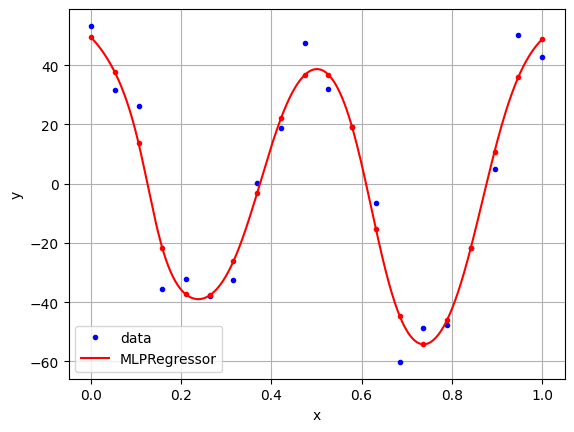

In [ ]:
model = MLPRegressor(hidden_layer_sizes=[100], activation='logistic', alpha=0.1, max_iter=5000, solver='lbfgs')
#model = MLPRegressor(hidden_layer_sizes=[100], activation='logistic', alpha=0.063, max_iter=200, solver='lbfgs')
model.fit(X_train, y_train)
plot_data(X_train, y_train, model)
print(f'  Train MSE: {mean_squared_error(y_train, model.predict(X_train))}')
print(f'    Val MSE: {mean_squared_error(y_val, model.predict(X_val))}')
print(f'   Test MSE: {mean_squared_error(y_test, model.predict(X_test))}')

## Exemplo: Character Font Images

### Conjunto de dados

O conjunto de dados abaixo é formado por imagens de dígitos (de 0 a 9) de diversas fontes tipográficas e corresponde a uma versão reduzida e simplificada do conjunto disponível em https://archive.ics.uci.edu/ml/datasets/Character+Font+Images. Para formar este conjunto reduzido foram selecionadas apenas as fontes geradas por computador e excluídas variações da mesma fonte, resultando em um total de 147 fontes, cada uma com 10 imagens (uma por dígito), organizadas em ordem alfabética. As imagens possuem 20x20 pixels, em tons de cinza, com valores de intensidade inteiros entre 0 e 255. O objetivo é classificar os dígitos em pares ($y=0$) ou ímpares ($y=1$).

As imagens de 107 fontes serão usadas para treinamento, de 20 fontes para validação e de 20 fontes para teste, totalizando 1070, 200 e 200 imagens, respectivamente.

É sempre uma boa prática normalizar os dados, o que, nesse caso, pode ser feito simplesmente dividindo-se cada atributo por 255, de forma que cada atributo esteja na faixa \[0, 1\].

In [ ]:
df = pd.read_csv('https://github.com/danilo-silva-ufsc/ml-course/raw/master/data/fontdigits.csv.gz', index_col=0)
#df = df.sort_values(['font', 'digit']).reset_index(drop=True)
df

,digit,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,9,AGENCY,AGENCY FB,57,0.4,0,0.0,35,24,51,...,255,255,255,255,255,255,255,255,165,60
1,8,AGENCY,AGENCY FB,56,0.4,0,0.0,35,24,51,...,255,255,255,255,255,255,255,255,165,60
2,7,AGENCY,AGENCY FB,55,0.4,0,0.0,35,22,51,...,27,1,1,1,1,1,1,1,1,1
3,6,AGENCY,AGENCY FB,54,0.4,0,0.0,35,24,51,...,255,255,255,255,255,255,255,255,165,60
4,5,AGENCY,AGENCY FB,53,0.4,0,0.0,35,24,51,...,255,255,255,255,255,255,255,255,165,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,4,YI BAITI,MICROSOFT YI BAITI,52,0.4,0,0.0,42,25,36,...,1,1,128,255,255,1,1,1,1,1
1466,3,YI BAITI,MICROSOFT YI BAITI,51,0.4,0,0.0,42,26,37,...,255,255,218,118,118,54,1,1,1,1
1467,2,YI BAITI,MICROSOFT YI BAITI,50,0.4,0,0.0,42,28,36,...,255,255,255,255,255,255,255,255,255,255
1468,1,YI BAITI,MICROSOFT YI BAITI,49,0.4,0,0.0,42,32,36,...,1,1,1,1,116,255,255,255,255,255


### Separando o conjunto de dados

In [ ]:
X = df.iloc[:, -400:].to_numpy()/255
y = df['digit'].to_numpy() % 2 # even or odd classification

X, X_test, y, y_test = train_test_split(X, y, test_size=200, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=200, random_state=0)
del X, y

In [ ]:
X = df.iloc[:, -400:].to_numpy()/255
y = df['digit'].to_numpy() % 2 # even or odd classification
g = df['font']

X, X_test, y, y_test, g, g_test = train_test_split(X, y, g, test_size=200, random_state=0)
X_train, X_val, y_train, y_val, g_train, g_val = train_test_split(X, y, g, test_size=200, random_state=0)
del X, y, g

In [ ]:
count = pd.DataFrame(index=df['font'].unique())
for s, g in zip(['train', 'val', 'test'], [g_train, g_val, g_test]):
    count[s] = g.value_counts()
count = count.sort_index().fillna(0).astype(int)
count

,train,val,test
AGENCY,3,2,5
ARIAL,7,2,1
BAITI,7,3,0
BANKGOTHIC,6,2,2
BASKERVILLE,9,0,1
...,...,...,...
VINETA,8,1,1
VIVALDI,7,0,3
VLADIMIR,8,1,1
WIDE,8,1,1


Veja mais em: https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data

In [ ]:
def group_train_test_split(*arrays, test_size=None, train_size=None, groups=None, random_state=None):
    # Based on https://scikit-learn.org/stable/modules/cross_validation.html#using-cross-validation-iterators-to-split-train-and-test
    # See also https://github.com/scikit-learn/scikit-learn/issues/9193#issuecomment-309951345
    from sklearn.model_selection import GroupShuffleSplit
    import pandas as pd
    def get(array, indices):
        if isinstance(array, pd.DataFrame) or isinstance(array, pd.Series):
            return array.iloc[indices]
        return array[indices]
    for array in arrays:
        assert len(array) == len(arrays[0])
    assert test_size is not None or train_size is not None
    train_test_ids = next(GroupShuffleSplit(test_size=test_size, train_size=train_size,
                                            random_state=random_state).split(arrays[0], groups=groups))
    return [get(a, ids) for a in arrays for ids in train_test_ids]

In [ ]:
X = df.iloc[:, -400:].to_numpy()/255
y = df['digit'].to_numpy() % 2 # even or odd classification
g = df['font']

# test_size now refers to the number of groups
X, X_test, y, y_test, g, g_test = group_train_test_split(X, y, g, test_size=20, groups=g, random_state=0)
X_train, X_val, y_train, y_val, g_train, g_val = group_train_test_split(X, y, g, test_size=20, groups=g, random_state=0)
del X, y, g

In [ ]:
count = pd.DataFrame(index=df['font'].unique())
for s, g in zip(['train', 'val', 'test'], [g_train, g_val, g_test]):
    count[s] = g.value_counts()
count = count.sort_index().fillna(0).astype(int)
count

,train,val,test
AGENCY,10,0,0
ARIAL,10,0,0
BAITI,0,10,0
BANKGOTHIC,10,0,0
BASKERVILLE,10,0,0
...,...,...,...
VINETA,10,0,0
VIVALDI,0,0,10
VLADIMIR,10,0,0
WIDE,10,0,0


In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape,   y_val.shape)
print(X_test.shape,  y_test.shape)

# save for later
X_train_orig = X_train.copy()
X_val_orig   = X_val.copy()
X_test_orig  = X_test.copy()

(1070, 400) (1070,)
(200, 400) (200,)
(200, 400) (200,)


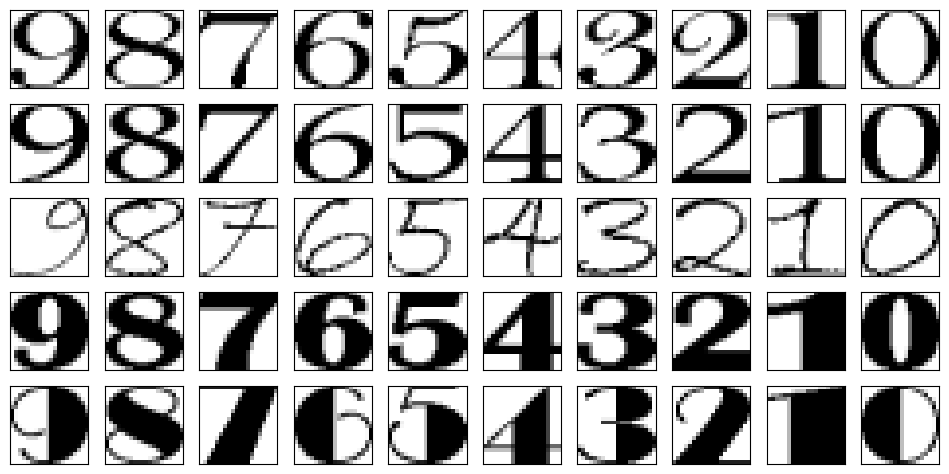

In [ ]:
plt.figure(figsize=(12,12))
for i in range(50, 100):
    plt.subplot(10, 10, i+1)
    plt.imshow(X_train_orig[i].reshape(20, 20), cmap='gray_r');
    plt.xticks([]);
    plt.yticks([]);

### Baseline: regressão logística

- Rede neural contendo somente uma unidade de saída, sem nenhuma camada oculta.

best alpha = 1.0
best score = 0.975


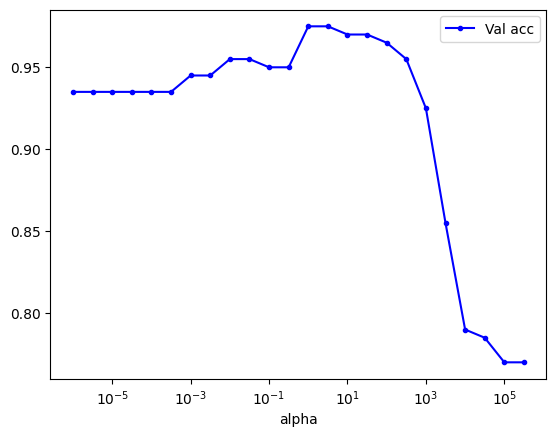

In [ ]:
param_grid = {'alpha': 10.0**np.arange(-6, 6, 0.5)}

gs = grid_search_holdout(MLPClassifier(hidden_layer_sizes=[], solver='lbfgs', random_state=0),
                         param_grid, X_train, y_train, X_val, y_val)

alpha = gs.best_params_['alpha']
print('best alpha =', alpha)
print('best score =', gs.best_score_)

plt.plot(gs.cv_results_['param_alpha'], gs.cv_results_['mean_test_score'], 'b.-', label='Val acc')
plt.xlabel('alpha')
plt.legend()
plt.xscale('log');

In [ ]:
model = MLPClassifier(hidden_layer_sizes=[], alpha=alpha, solver='lbfgs', random_state=0)
model.fit(X_train, y_train)
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')
print(f' Test accuracy: {model.score(X_test, y_test):.1%}')

Train accuracy: 99.5%
  Val accuracy: 97.5%
 Test accuracy: 93.0%


### Dificultando o problema

Claramente, esse é um problema fácil demais, então vamos dificultá-lo. Para isso, escolheremos como atributos **apenas 7 pixels** aleatórios da imagem.

In [ ]:
cols = np.random.RandomState(0).permutation(400)[:7]
X_train = X_train_orig[:, cols]
X_val = X_val_orig[:, cols]
X_test = X_test_orig[:, cols]

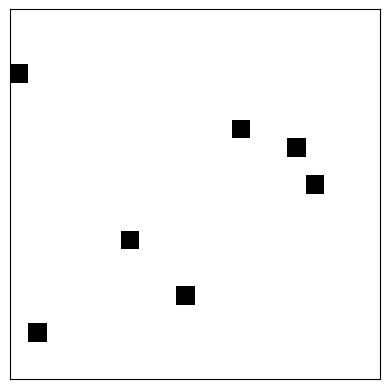

In [ ]:
mask = np.zeros(400)
mask[cols] = 1
plt.imshow(mask.reshape(20, 20), cmap='gray_r');
plt.xticks([]);
plt.yticks([]);

best alpha = 1e-06
best score = 0.645


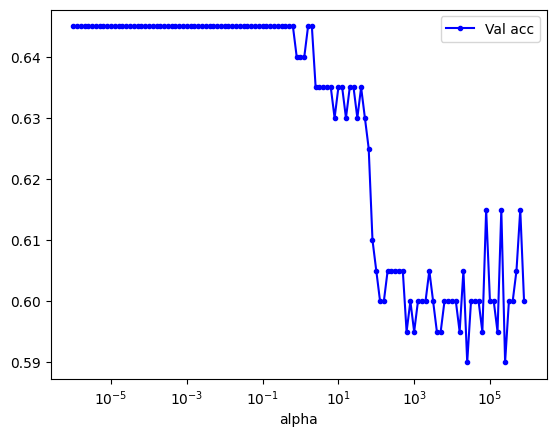

In [ ]:
param_grid = {'alpha': 10.0**np.arange(-6, 6, 0.1)}

gs = grid_search_holdout(MLPClassifier(hidden_layer_sizes=[], solver='lbfgs', random_state=0),
                         param_grid, X_train, y_train, X_val, y_val)

alpha = gs.best_params_['alpha']
print('best alpha =', alpha)
print('best score =', gs.best_score_)

plt.plot(gs.cv_results_['param_alpha'], gs.cv_results_['mean_test_score'], 'b.-', label='Val acc')
plt.xlabel('alpha')
plt.legend()
plt.xscale('log');

In [ ]:
model = MLPClassifier(hidden_layer_sizes=[], alpha=alpha, solver='lbfgs', random_state=0)
model.fit(X_train, y_train)
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')
print(f' Test accuracy: {model.score(X_test, y_test):.1%}')

Train accuracy: 66.6%
  Val accuracy: 64.5%
 Test accuracy: 62.5%


### Redes neurais

- Inicialmente, garantir que a arquitetura da rede é suficiente para evitar underfitting (i.e., conseguir alta acurácia de treinamento)
- Em seguida, controlar o overfitting (através de regularização e/ou número máximo de iterações)

In [ ]:
class ignore_warning:
    def __init__(self, msg='lbfgs failed to converge'):
        self.msg = msg
    def __enter__(self):
        import warnings
        warnings.filterwarnings('ignore', self.msg)
    def __exit__(self, exc_type, exc_val, exc_tb):
        import warnings
        warnings.filterwarnings('default', self.msg)

In [ ]:
@interact(activation=['identity', 'logistic', 'tanh', 'relu'], n_hid_layers=(0,4), hid_layer_size=(1,200),
          alpha=FloatLogSlider(value=0, min=-6, max=0, step=0.5, readout_format='.2e'), max_iter=(100,2000,100), random_state=(0,20))
def _(activation='logistic', n_hid_layers=1, hid_layer_size=10, alpha=None, max_iter=200, random_state=0):
    model = MLPClassifier(hidden_layer_sizes=[hid_layer_size]*n_hid_layers, activation=activation, alpha=alpha, solver='lbfgs', max_iter=max_iter, random_state=random_state)
    with ignore_warning():
        model.fit(X_train, y_train)
    print('Iterations:', model.n_iter_)
    print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
    print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')
    #hid_layer_size=50, max_iter=200, alpha=1e-3
    #hid_layer_size=100, max_iter=200, alpha=1e-2

interactive(children=(Dropdown(description='activation', index=1, options=('identity', 'logistic', 'tanh', 're…

In [ ]:
#model = MLPClassifier(hidden_layer_sizes=[50], alpha=1e-3, activation='logistic', solver='lbfgs', random_state=0)
model = MLPClassifier(hidden_layer_sizes=[100], alpha=1e-2, activation='logistic', solver='lbfgs', random_state=0)
with ignore_warning():
    model.fit(X_train, y_train)
print(f'Train accuracy: {model.score(X_train, y_train):.1%}')
print(f'  Val accuracy: {model.score(X_val, y_val):.1%}')
print(f' Test accuracy: {model.score(X_test, y_test):.1%}')

Train accuracy: 81.3%
  Val accuracy: 78.0%
 Test accuracy: 70.5%


In [ ]:
from sklearn.model_selection import GroupKFold
with ignore_warning():
    #val_accs = cross_val_score(model, X_train, y_train, cv=2) # does not use groups
    #val_accs = cross_val_score(model, X_train, y_train, groups=g_train, cv=2) # does not use groups
    #val_accs = cross_val_score(model, X_train, y_train, groups=g_train, cv=GroupKFold(n_splits=2))
    val_accs = cross_val_score(model, X_train, y_train, groups=g_train, cv=GroupKFold(n_splits=5))
print(f'5-fold accuracy: {val_accs.mean():.1%}')

5-fold accuracy: 75.9%


## TensorFlow Playground

Experimente em: https://playground.tensorflow.org

In [ ]:
import numpy as np

input_size = 10
hidden_size = 50
output_size = 1

W1 = np.random.randn(input_size, hidden_size)
b1 = np.random.randn(hidden_size)

W2 = np.random.randn(hidden_size, output_size)
b2 = np.random.randn(output_size)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1, input_size)

z1 = np.dot(x, W1) + b1
a1 = sigmoid(z1)

z2 = np.dot(a1, W2) + b2
y_hat = sigmoid(z2)

print("Dimensões das matrizes e vetores:")
print("W1 (entrada para oculta):", W1.shape)
print("b1 (bias da oculta):", b1.shape)
print("W2 (oculta para saída):", W2.shape)
print("b2 (bias da saída):", b2.shape)
print("\nSaída da rede (y_hat):", y_hat)


Dimensões das matrizes e vetores:
W1 (entrada para oculta): (10, 50)
b1 (bias da oculta): (50,)
W2 (oculta para saída): (50, 1)
b2 (bias da saída): (1,)

Saída da rede (y_hat): [[0.00946278]]


In [ ]:
x.shape

(1, 10)

In [ ]:
z2.shape

(1, 1)

In [ ]:
y_hat.shape

(1, 1)

In [ ]:
b2.shape

(1,)